In [ ]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


os.chdir('/private/home/changanvr/Projects/ss-local')
dataset = 'gibson' # or replace with 'mp3d', one example for each dataset

backend_cfg = habitat_sim.SimulatorConfiguration()
if dataset == 'mp3d':
    backend_cfg.scene_id = "data/scene_datasets/mp3d/UwV83HsGsw3/UwV83HsGsw3.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/mp3d/mp3d.scene_dataset_config.json"
else:
    backend_cfg.scene_id = "data/scene_datasets/gibson/Oyens.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)

# set navmesh path for searching for navigable points
if dataset == 'mp3d':
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/mp3d/UwV83HsGsw3/UwV83HsGsw3.navmesh"))
else:
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))

audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True
audio_sensor_spec.channelLayout.type = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 1
# audio sensor location set with respect to the agent
audio_sensor_spec.position = [0.0, 1.5, 0.0]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True
sim.add_sensor(audio_sensor_spec)

audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
audio_sensor.setAudioMaterialsJSON("data/mp3d_material_config.json")

In [15]:
# sampled navigable point is on the floor
source_pos = sim.pathfinder.get_random_navigable_point()
print('Sample source location: ', source_pos)

Sample source location:  [2.6282403  0.01496243 6.8579893 ]


In [16]:
audio_sensor.setAudioSourceTransform(source_pos + np.array([0, 1.5, 0])) # add 1.5m to the height calculation 
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()
new_state.position = np.array(source_pos + np.array([2, 0, 0]))
new_state.sensor_states = {}
agent.set_state(new_state, True)
ir = np.array(sim.get_sensor_observations()["audio_sensor"])
print(ir.shape)

# one a category is not found in the material mapping file, the default acoustic material will be used.

CreateContext: Context created
(2, 65620)


Material for category 'bottle' was not found. Using default material instead.
Material for category 'refrigerator' was not found. Using default material instead.
Material for category 'couch' was not found. Using default material instead.
Material for category 'vase' was not found. Using default material instead.
Material for category 'book' was not found. Using default material instead.
Material for category 'bowl' was not found. Using default material instead.
Material for category 'oven' was not found. Using default material instead.
Material for category 'toothbrush' was not found. Using default material instead.


In [17]:
# check if the direct sound is present (source is visibile from the listener)
audio_sensor.sourceIsVisible()

True

In [18]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
audio_sensor.getRayEfficiency()

0.7667155265808105

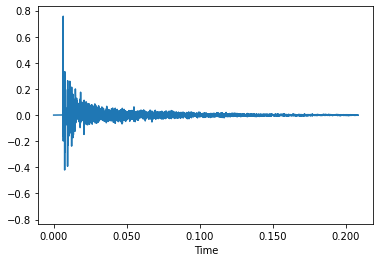

In [19]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython

waveshow(ir[0, :10000], 48000)
IPython.display.Audio(ir, rate=48000)

In [21]:
# one example for how to use IR data to get the reverberant speech
sr, vocal = wavfile.read('res/singing.wav')
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

48000 (233873,)


/tmp/ipykernel_915323/3675352108.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, vocal = wavfile.read('res/singing.wav')


In [22]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

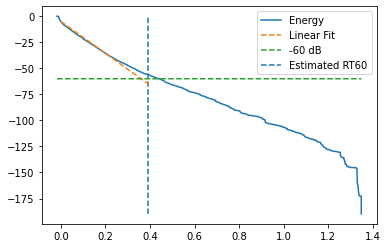

RT60 of the rendered IR is 0.3927 seconds


In [23]:
from pyroomacoustics.experimental.rt60 import measure_rt60

rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
print(f'RT60 of the rendered IR is {rt60:.4f} seconds')